In [ ]:
# В принципе задача решена, но хочу добавить многоклассовую лог регрессию. Прошу дать пару дней и повременить с проверкой! :)

# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [5]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

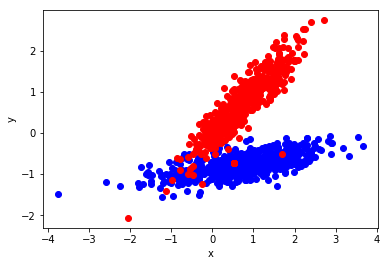

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [21]:
def linear_op_forward(X, W, b):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) + b  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    db = tf.reduce_sum(grads)
    return dX, dW, db

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.exp(-X))

def sigmoid_op_backward(op, grads):
    #print('op', op.inputs[0] , 'grad',grads)
    y_pred = op.inputs[0]  # тензор входных данных
       
    g = tf.multiply(tf.sigmoid(y_pred),tf.subtract(tf.constant(1.0),tf.sigmoid(y_pred)))
    
    d = tf.multiply(grads, g)
    
    # TODO: реализовать вычисление градиента для sigmoid
    return d

## Создание графа вычислений и обучение модели

In [45]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
b = None
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])
    
    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_b = tf.Variable(0.5, name='var_b')
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_b],     # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for _ in range(10):
        for epoch in range(10):
        
            # вначале каждой эпохи перемешиваем индексы
            np.random.shuffle(indices)
        
            # внутри каждой эпохи данные разбиваются на батчи
            for batch in range(len(X) // BATCH_SIZE):
            
                # выбираем индексы очередного батча
                batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

                # выполняем шаг обучения: вычисляем ошибку и обновляем веса
                loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                                   feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                                plh_labels: y[batch_indices]})
        
                # сохраняем занчения ошибки для построения кривой обучения
                learning_curve.append(loss)
            
                # выводим текущее значение ошибки для каждого 10го шага
                steps = len(learning_curve) - 1
                if steps % 50 == 0:
                    print('[%03d] loss=%.3f weights=%s b=%s' % (steps, loss, var_W.eval(), var_b.eval()))
    
        # сохраняем обученные веса
        weights = var_W.eval()
        b = var_b.eval()

[000] loss=0.805 weights=[[0.41123405 0.22184856]] b=0.48355493
[050] loss=0.616 weights=[[ 0.04098568 -1.4641958 ]] b=-0.22652714
[100] loss=0.582 weights=[[ 0.24424803 -2.2958536 ]] b=-0.5077737
[150] loss=0.587 weights=[[ 0.43851274 -2.8363738 ]] b=-0.72528017
[200] loss=0.523 weights=[[ 0.59929  -3.241083]] b=-0.90827256
[250] loss=0.569 weights=[[ 0.73065215 -3.5641205 ]] b=-1.080145
[300] loss=0.565 weights=[[ 0.84452176 -3.8350883 ]] b=-1.2282109
[350] loss=0.561 weights=[[ 0.93746763 -4.074548  ]] b=-1.3494238
[400] loss=0.500 weights=[[ 1.0222296 -4.287268 ]] b=-1.4596117
[450] loss=0.556 weights=[[ 1.0927187 -4.477234 ]] b=-1.5663782
[500] loss=0.526 weights=[[ 1.1571494 -4.6527576]] b=-1.6543655
[550] loss=0.552 weights=[[ 1.2154385 -4.8136196]] b=-1.7395083
[600] loss=0.528 weights=[[ 1.2676922 -4.964278 ]] b=-1.8178834
[650] loss=0.526 weights=[[ 1.3125634 -5.107184 ]] b=-1.8852938
[700] loss=0.531 weights=[[ 1.3607574 -5.237449 ]] b=-1.9548355
[750] loss=0.520 weights=[[ 

## Визуализируем кривую обучения

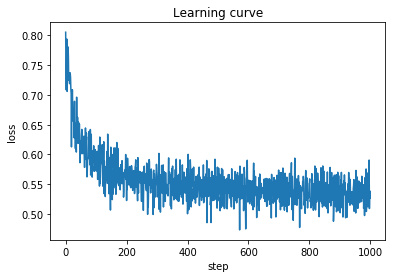

In [46]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

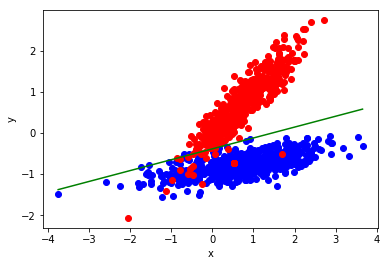

In [47]:
y_pred = - (X[:, 0] * weights[0, 0]+b) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000
NUM_CLASSES = 3

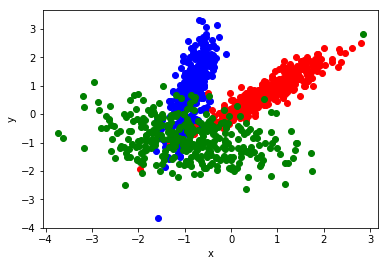

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = 2,
                           n_redundant = 0,
                           n_classes = NUM_CLASSES,
                           n_clusters_per_class = 1,
                           class_sep = 0.85,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'
duos = np.where(y == 2)   # индексы объектов класса '2'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[duos, 0], X[duos, 1], 'og');

In [7]:
y_l = np.zeros([NUM_SAMPLES, NUM_CLASSES])
y_l

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [8]:
for i in range(len(y_l)):
    y_l[i, y[i]] = 1
y_l
    

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [75]:

with tf.Session() as sess: 
    #var_W = tf.Variable(tf.random_uniform(shape = [NUM_CLASSES,NUM_FEATURES],
    #                                      dtype = tf.float32,
    #                                      seed = 54321))
    #var_X = tf.Variable(tf.random_uniform(shape = [NUM_SAMPLES, NUM_FEATURES],
    #                                      dtype = tf.float32,
    #                                      seed = 54321))
    #var_b = tf.Variable(tf.random_uniform(shape = [3, 1],
    #                                      dtype = tf.float32,
    #                                      seed = 54321))
    
    var_W = tf.Variable(np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]]))
    var_X = tf.Variable(np.array([[0.1,0.2],[0.3,0.4],[0.5,0.6],[0.7,0.8]]))
    var_b = tf.Variable(np.array([[1.0],[2.0],[3.0]]))
    #f = tf.transpose(tf.add(tf.reduce_sum(tf.multiply(var_W, var_X), axis = 2),var_b))
    f = tf.multiply(var_X, var_W)
    var_W.initializer.run()
    var_X.initializer.run()
    var_b.initializer.run()
    res = f.eval(session=sess)
    print(res)
    print(var_W.shape)
    print(var_X.shape)
    print(var_b.shape)
    print(res.shape)

ValueError: Dimensions must be equal, but are 4 and 3 for 'Mul_53' (op: 'Mul') with input shapes: [4,2], [3,2].

In [ ]:
[[0.1 0.4]
 [0.9 1.6]
 [2.5 3.6]
 [4.9 6.4]]


[[3.5 5.6]
 [3.5 5.6]
 [3.5 5.6]
 [3.5 5.6]]

In [76]:
def linear_op_forward(X, W, b):
    print('X',X.shape,'W', W.shape,'b', b.shape)
    ''' Реализация линейной операции '''
    res=np.array([NUM_CLASSES, NUM_FEATURES])
    for i in renge(NUM_CLASSES):
        res[i] = np.dot(X, W[i].T) + b 
    return res 

def linear_op_backward(op, grads):
    
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    print('X', X.shape, 'W', W.shape, 'grads', grads.shape)
    dX = tf.multiply(grads, W)
   
    for i in renge(NUM_CLASSES):
        dW=np.array([NUM_CLASSES, NUM_FEATURES])
        db=np.array([NUM_CLASSES, NUM_FEATURES])
        dW[i] = tf.reduce_sum(tf.multiply(X, grads[i]),
                       axis = 0,
                       keep_dims = True)
        db[i] = tf.reduce_sum(grads[i], axis = 1)
    print('dX', dX.shape, 'dW',dW.shape, 'db', db.shape)
    return dX, dW, db

def sigmoid_op_forward(X):
    print('X', X.shape)
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.exp(-X))

def sigmoid_op_backward(op, grads):
    
    #print('op', op.inputs[0] , 'grad',grads)
    y_pred = op.inputs[0]  # тензор входных данных
    print('y_pred', y_pred.shape,  'grads', grads.shape)  
    g = tf.multiply(tf.sigmoid(y_pred),tf.subtract(tf.constant(1.0),tf.sigmoid(y_pred)))
    
    d = tf.multiply(grads, g)
    
    # TODO: реализовать вычисление градиента для sigmoid
    return d

In [78]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
b = None
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 3])
    
    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [NUM_CLASSES, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_b = tf.Variable(tf.random_uniform(shape = [3, 1],
                                          dtype = tf.float32,
                                          seed = 54321)))
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_b],     # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for _ in range(10):
        for epoch in range(10):
        
            # вначале каждой эпохи перемешиваем индексы
            np.random.shuffle(indices)
        
            # внутри каждой эпохи данные разбиваются на батчи
            for batch in range(len(X) // BATCH_SIZE):
            
                # выбираем индексы очередного батча
                batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

                # выполняем шаг обучения: вычисляем ошибку и обновляем веса
                loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                                   feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                                plh_labels: y_l[batch_indices]})
        
                # сохраняем занчения ошибки для построения кривой обучения
                learning_curve.append(loss)
            
                # выводим текущее значение ошибки для каждого 10го шага
                steps = len(learning_curve) - 1
                if steps % 50 == 0:
                    print('[%03d] loss=%.3f weights=%s b=%s' % (steps, loss, var_W.eval(), var_b.eval()))
    
        # сохраняем обученные веса
        weights = var_W.eval()
        b = var_b.eval()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 64)